In [1]:
import pandas as pd
from Bio import SeqIO
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.tree import DecisionTreeClassifier

In [3]:
DATASET_PATH = os.path.join(os.getcwd(), "Cov dataset statewise fasta")
MODEL_PATH = os.path.join(os.getcwd(), "Model files")
os.listdir(DATASET_PATH)

['Andaman and Nicobar Islands.fasta',
 'andaman_nicobar.fasta',
 'Andhra Pradesh.fasta',
 'andhra_pradesh.fasta',
 'Arunachal Pradesh.fasta',
 'arunachal_pradesh.fasta',
 'Assam.fasta',
 'Bihar.fasta',
 'Chandigarh.fasta',
 'Chhattisgarh.fasta',
 'Dadra and Nagar Haveli.fasta',
 'dadra_nagar_haveli.fasta',
 'Daman and Diu.fasta',
 'daman_diu.fasta',
 'Delhi.fasta',
 'Goa.fasta',
 'Gujarat.fasta',
 'Haryana.fasta',
 'Himachal Pradesh.fasta',
 'himachal_pradesh.fasta',
 'Jammu and Kashmir.fasta',
 'jammu_kashmir.fasta',
 'Jharkhand.fasta',
 'Karnataka.fasta',
 'Kerala.fasta',
 'Ladakh.fasta',
 'Lakshadweep.fasta',
 'Madhya Pradesh.fasta',
 'madhya_pradesh.fasta',
 'Maharashtra.fasta',
 'Manipur.fasta',
 'Meghalaya.fasta',
 'Mizoram.fasta',
 'Nagaland.fasta',
 'Odisha.fasta',
 'Puducherry.fasta',
 'Punjab.fasta',
 'Rajasthan.fasta',
 'Sikkim.fasta',
 'Tamil Nadu.fasta',
 'tamil_nadu.fasta',
 'Telangana.fasta',
 'Tripura.fasta',
 'Uttar Pradesh.fasta',
 'Uttarakhand.fasta',
 'uttar_pradesh

In [3]:
CSV_PATH = os.path.join(os.getcwd(), "Cov dataset statewise fasta", "data.csv")

df = pd.DataFrame(columns=["ID", "State/UT", "Sequence"])

In [29]:
for fasta in os.listdir(DATASET_PATH):
    if fasta.endswith(".fasta"):
        for seq_record in SeqIO.parse(DATASET_PATH + "/" + fasta, "fasta"):
            # save the record to dataframe
            df = pd.concat([df, pd.DataFrame([[seq_record.id, fasta[:-6], seq_record.seq]], columns=["ID", "State/UT", "Sequence"])], ignore_index=True)


df.to_csv(CSV_PATH, index=False)

In [4]:
df = pd.read_csv(r"D:\data.csv")

In [5]:
df.head()

,ID,State/UT,Sequence
0,hCoV-19/India/MH-GA22/2020|EPI_ISL_508218|2020...,Maharashtra,ACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACG...
1,hCoV-19/India/MH-ACTREC-219/2020|EPI_ISL_69987...,Maharashtra,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...
2,hCoV-19/India/MH-NCCS-NR2254/2020|EPI_ISL_4965...,Maharashtra,AAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAA...
3,hCoV-19/India/MH-ACTREC-119/2020|EPI_ISL_69977...,Maharashtra,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...
4,hCoV-19/India/MH-ACTREC-087/2020|EPI_ISL_69974...,Maharashtra,CCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCT...


In [6]:
x = df["Sequence"]
y = df["State/UT"]

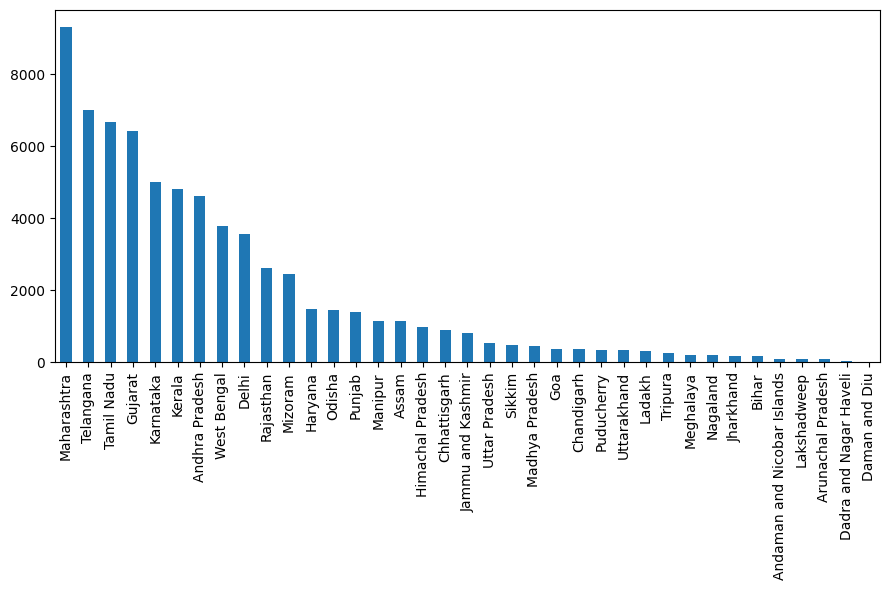

In [7]:
plt.figure(figsize=(9, 6))
y.value_counts().plot(kind="bar")
plt.tight_layout()
plt.show()

In [8]:
print(len(y.unique()))

37


## Train Test Split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## K-Merize

In [10]:
# convert sequence to k mer words of length n
def getKmers(sequence, size=3):
    seq = [sequence[x:x + size].lower() for x in range(len(sequence) - size + 1)]
    n_str = "n"*size
    seq = [x if n_str not in x else "" for x in seq]
    seq = " ".join(seq)
    return seq


In [11]:
x_train = x_train.apply(lambda x: getKmers(x))
x_test = x_test.apply(lambda x: getKmers(x))

# convert it to an array of strings
x_train = np.array(x_train)
x_test = np.array(x_test)

## Count Vectorizer

In [18]:
# create a count vectorizer
cv = CountVectorizer(ngram_range=(2,2))

# fit and transform x_train
x_train = cv.fit_transform(x_train)
# transform x_test
x_test = cv.transform(x_test)

In [23]:
# save the count vectorizer
pickle.dump(cv, open(MODEL_PATH + "\count_vectorizer_state_ut.pkl", "wb"))

In [11]:
# load the count vectorizer
cv = pickle.load(open(MODEL_PATH + "\count_vectorizer_state_ut.pkl", "rb"))

x_train = cv.fit_transform(x_train)
x_test = cv.transform(x_test)

x_train = x_train.toarray()
x_test = x_test.toarray()

In [21]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Deep Learning

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [13]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# save the label encoder
pickle.dump(le, open(MODEL_PATH + "\label_encoder_state_ut.pkl", "wb"))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [27]:
# oversample using SMOTE
sm = SMOTE(random_state=42)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

In [30]:
ros = RandomOverSampler(random_state=42)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

In [31]:
model = Sequential()
model.add(Dense(512, input_shape=(x_train_sm.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(y_train_sm.shape[1], activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 512)               1338880   
                                                                 
 batch_normalization_15 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 512)               0         
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_16 (Bat  (None, 256)              1024      
 chNormalization)                                     

In [32]:
model.fit(x_train_ros, y_train_ros, epochs=50, batch_size=128, validation_data=(x_test, y_test))

model.save(MODEL_PATH + "\state_ut_model.h5")

Epoch 1/50
2153/2153 [==============================] - 47s 21ms/step - loss: 1.3542 - accuracy: 0.6037 - val_loss: 77.4001 - val_accuracy: 0.0925
Epoch 2/50
2153/2153 [==============================] - 47s 22ms/step - loss: 0.7667 - accuracy: 0.7626 - val_loss: 59.6517 - val_accuracy: 0.0176
Epoch 3/50
 188/2153 [=>............................] - ETA: 38s - loss: 0.6408 - accuracy: 0.7973

KeyboardInterrupt: 

## Random Forest

In [45]:
# create a random forest classifier
rf_classifier = RandomForestClassifier()
# fit the classifier to x_train and y_train
rf_classifier.fit(x_train_sm, y_train_)
# predict the labels of x_test
y_pred = rf_classifier.predict(x_test)
# print the accuracy score
print("Accuracy:", accuracy_score(y_test_, y_pred))


Accuracy: 0.7447081462475946


In [41]:
# revert one hot encoding
y_train_ = np.argmax(y_train_ros, axis=1)

# revert label encoding
y_train_ = le.inverse_transform(y_train_)

## decision tree

In [42]:
dt = DecisionTreeClassifier()
dt.fit(x_train_ros, y_train_)
y_pred = dt.predict(x_test)



ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [44]:
# print the accuracy score
print("Accuracy score: ", accuracy_score(y_test_, y_pred))

# save the model
#pickle.dump(dt, open(MODEL_PATH + "\decision_tree_state_ut.pkl", "wb"))

Accuracy score:  0.46739362839426984


In [14]:
# save the model to a pickle file
pickle.dump(rf_classifier, open(MODEL_PATH + r"\random_forest_classifier_state.pkl", "wb"))

NameError: name 'rf_classifier' is not defined

In [31]:
sklearn_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(sklearn_accuracy*100))


Accuracy: 73.85%


In [33]:
conf_mat = confusion_matrix(y_test, y_pred)

In [ ]:
classification_report(y_test, y_pred)

## Balance the Dataset

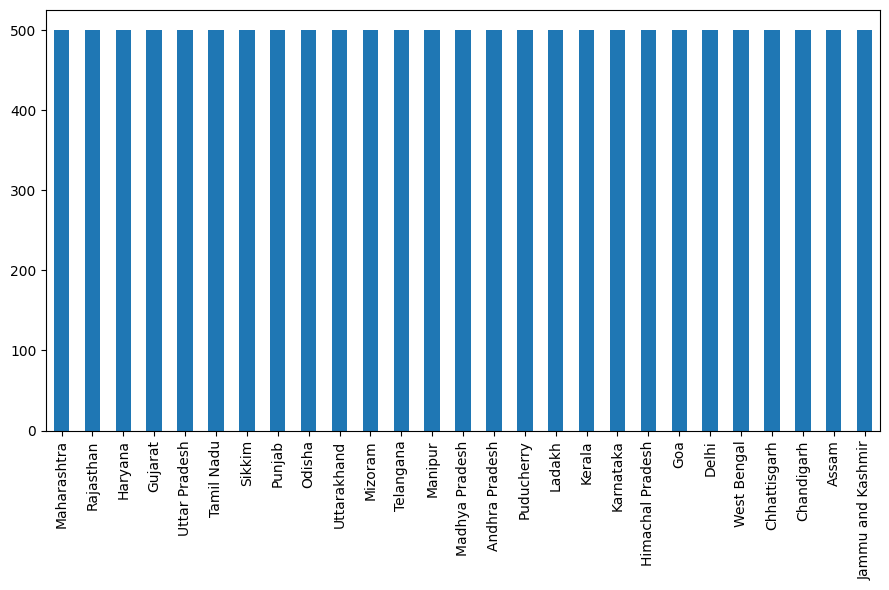

In [69]:

state_ut_list = list(df["State/UT"].unique())

df1 = pd.DataFrame(columns=["ID", "State/UT", "Sequence"])
for state_ut in state_ut_list:
    if len(df[df["State/UT"] == state_ut]) < 500 and len(df[df["State/UT"] == state_ut]) > 250:
        df1 = pd.concat([df1, df[df["State/UT"] == state_ut]], ignore_index=True)
    elif len(df[df["State/UT"] == state_ut]) > 500:
        indexes = np.random.choice(df[df["State/UT"] == state_ut].index, 500, replace=False)
        df1 = pd.concat([df1, df.iloc[indexes]], ignore_index=True)
    
# 

x = df1["Sequence"]
y = df1["State/UT"]

ros = RandomOverSampler(random_state=42)
x, y = ros.fit_resample(np.array(x).reshape(-1, 1), y)

plt.figure(figsize=(9, 6))
y.value_counts().plot(kind="bar")
plt.tight_layout()
plt.show()


In [70]:
x = pd.DataFrame(x, columns=["Sequence"])
y = pd.DataFrame(y, columns=["State/UT"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = x_train.apply(lambda x: getKmers(x["Sequence"]), axis=1)
x_test = x_test.apply(lambda x: getKmers(x["Sequence"]), axis=1)

# convert it to an array of strings
x_train = np.array(x_train)
x_test = np.array(x_test)

# create a count vectorizer
cv = CountVectorizer(ngram_range=(2,2))

# fit and transform x_train
x_train = cv.fit_transform(x_train)
# transform x_test
x_test = cv.transform(x_test)

# save the count vectorizer
pickle.dump(cv, open(MODEL_PATH + "\count_vectorizer_state_ut_balanced.pkl", "wb"))

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# create a random forest classifier# create a random forest classifier
rf_classifier = RandomForestClassifier()
# fit the classifier to x_train and y_train
rf_classifier.fit(x_train, y_train)
# predict the labels of x_test
y_pred = rf_classifier.predict(x_test)


# save the model to a pickle file
pickle.dump(rf_classifier, open(MODEL_PATH + r"\random_forest_classifier_state_balanced.pkl", "wb"))

In [71]:
sklearn_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(sklearn_accuracy*100))

Accuracy: 62.11%


In [129]:
x = df["Sequence"]
y = df["State/UT"]

# select 20000 random samples
indexes = np.random.choice(df.index, 10000, replace=False)

x = x.iloc[indexes]
y = y.iloc[indexes]

# load the count vectorizer
cv = pickle.load(open(MODEL_PATH + "\count_vectorizer_state_ut.pkl", "rb"))

x = x.apply(lambda x: getKmers(x))
x = np.array(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# fit and transform x_train
x_train = cv.transform(x_train)
# transform x_test
x_test = cv.transform(x_test)

In [130]:
x_train = x_train.toarray()
x_test = x_test.toarray()

In [140]:
ros = RandomOverSampler()
x_train, y_train = ros.fit_resample(x_train, y_train)

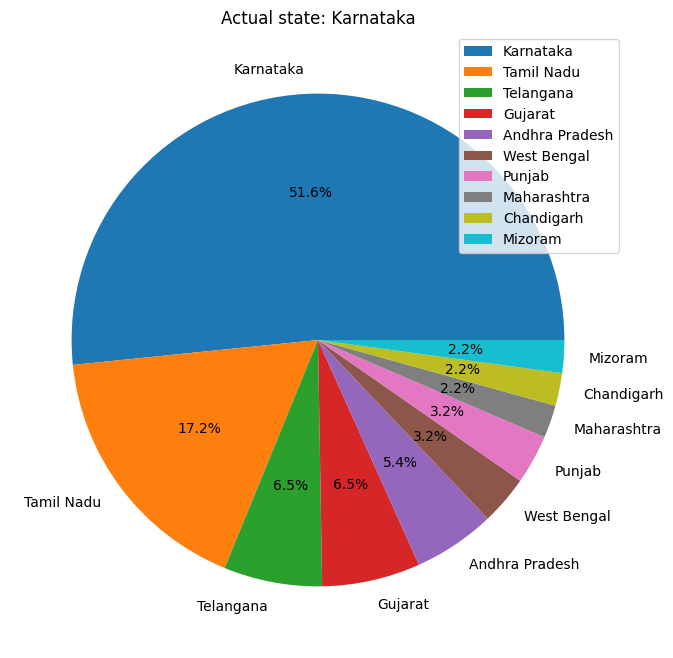

In [197]:
index = np.random.choice(df.index)
xt = df.iloc[index]["Sequence"]
yt = df.iloc[index]["State/UT"]

xt = getKmers(xt)

cv = pickle.load(open(MODEL_PATH + "\count_vectorizer_state_ut.pkl", "rb"))
xt = cv.transform([xt])

xt = xt.toarray()

rf = pickle.load(open(MODEL_PATH + r"\random_forest_classifier_state.pkl", "rb"))

# predict the top 10 states
top_5 = rf.predict_proba(xt)[0].argsort()[-10:][::-1]

# get the top 10 states
top_5_states = [rf.classes_[i] for i in top_5]

# get the top 10 probabilities
top_5_prob = [rf.predict_proba(xt)[0][i] for i in top_5]

# get the actual state
actual_state = yt

# display the results in a pie chart
plt.figure(figsize=(15, 8))
plt.pie(top_5_prob, labels=top_5_states, autopct="%1.1f%%")
plt.title("Actual state: " + actual_state)
# legend showing states
plt.legend(top_5_states)
plt.show()

In [8]:
x = df["Sequence"]
y = df["State/UT"]

# select 10000 random samples
indexes = np.random.choice(df.index, 10000, replace=False)

x = x.iloc[indexes]
y = y.iloc[indexes]

# load the count vectorizer
cv = pickle.load(open(MODEL_PATH + "\count_vectorizer_state_ut.pkl", "rb"))

x = x.apply(lambda x: getKmers(x))
x = np.array(x)

# transform x
x = cv.transform(x)

x = x.toarray()

# load the random forest classifier
rf = pickle.load(open(MODEL_PATH + r"\random_forest_classifier_state.pkl", "rb"))


KeyError: '[0, 4, 5, 6, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 65, 66, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 85, 86, 87, 89, 90, 91, 92, 93, 94, 96, 97, 99, 100, 102, 103, 104, 106, 107, 108, 110, 111, 112, 113, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 169, 171, 172, 173, 174, 175, 176, 177, 178, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 231, 232, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 262, 264, 265, 266, 268, 269, 270, 271, 272, 273, 275, 277, 278, 279, 281, 282, 283, 284, 285, 286, 288, 289, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 316, 317, 318, 319, 320, 321, 322, 323, 325, 326, 327, 328, 329, 330, 331, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 395, 396, 397, 398, 400, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 428, 429, 430, 431, 433, 434, 435, 436, 437, 438, 439, 440, 441, 443, 444, 445, 447, 448, 450, 451, 452, 453, 455, 456, 457, 458, 459, 460, 462, 464, 465, 467, 468, 470, 471, 472, 473, 474, 476, 477, 478, 479, 480, 481, 483, 484, 485, 487, 488, 489, 490, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 507, 508, 510, 511, 513, 514, 515, 516, 517, 518, 519, 521, 522, 523, 524, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 602, 603, 604, 605, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 630, 631, 632, 633, 634, 636, 637, 638, 639, 640, 642, 644, 645, 646, 647, 648, 649, 652, 653, 655, 656, 657, 658, 659, 660, 661, 665, 666, 667, 668, 670, 671, 672, 673, 675, 676, 677, 678, 679, 680, 682, 683, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 697, 698, 699, 701, 702, 703, 704, 705, 707, 708, 709, 710, 711, 712, 713, 714, 715, 717, 718, 719, 720, 721, 723, 724, 725, 726, 727, 728, 729, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 763, 764, 765, 766, 767, 768, 769, 771, 772, 773, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 793, 794, 795, 797, 798, 800, 801, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 825, 826, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 846, 847, 848, 849, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 871, 873, 874, 875, 876, 877, 879, 880, 881, 882, 883, 885, 886, 888, 889, 890, 891, 892, 893, 895, 896, 897, 898, 899, 901, 902, 903, 904, 905, 906, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 920, 921, 922, 923, 924, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 940, 941, 943, 944, 945, 946, 947, 948, 949, 952, 953, 954, 955, 956, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 973, 974, 975, 977, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 991, 992, 993, 994, 995, 996, 997, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1028, 1029, 1031, 1032, 1033, 1034, 1036, 1037, 1038, 1039, 1040, 1042, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1056, 1057, 1058, 1059, 1060, 1061, 1063, 1064, 1068, 1070, 1071, 1072, 1073, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1087, 1088, 1089, 1091, 1092, 1093, 1094, 1095, 1096, 1098, 1099, 1101, 1102, 1103, 1106, 1107, 1108, 1109, 1110, 1111, 1113, 1114, 1115, 1116, 1117, 1119, 1120, 1121, 1122, 1123, 1124, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1138, 1140, 1141, 1144, 1145, 1146, 1147, 1149, 1151, 1152, 1154, 1155, 1156, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1184, 1185, 1187, 1188, 1189, 1190, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1209, 1210, 1211, 1212, 1213, 1214, 1216, 1217, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1234, 1235, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1257, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1303, 1305, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1334, 1335, 1336, 1337, 1338, 1340, 1341, 1343, 1344, 1345, 1346, 1349, 1350, 1351, 1352, 1353, 1354, 1356, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1367, 1368, 1369, 1370, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1381, 1382, 1383, 1384, 1385, 1386, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1411, 1412, 1414, 1415, 1416, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1436, 1437, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1453, 1454, 1455, 1456, 1457, 1458, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1468, 1470, 1471, 1472, 1473, 1474, 1476, 1477, 1480, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1518, 1519, 1521, 1522, 1523, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1567, 1569, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1629, 1630, 1631, 1632, 1634, 1636, 1637, 1638, 1641, 1642, 1643, 1644, 1645, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1666, 1667, 1668, 1670, 1671, 1672, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1686, 1687, 1688, 1689, 1690, 1692, 1694, 1695, 1697, 1698, 1699, 1703, 1704, 1705, 1706, 1708, 1709, 1710, 1711, 1712, 1713, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1727, 1728, 1729, 1730, 1731, 1733, 1734, 1735, 1737, 1738, 1739, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1784, 1785, 1788, 1790, 1791, 1792, 1793, 1794, 1795, 1797, 1798, 1799, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1842, 1843, 1845, 1846, 1847, 1848, 1849, 1850, 1853, 1854, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1889, 1890, 1891, 1892, 1893, 1895, 1896, 1897, 1898, 1899, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1933, 1934, 1935, 1936, 1938, 1939, 1940, 1942, 1943, 1944, 1945, 1946, 1948, 1949, 1950, 1951, 1952, 1953, 1955, 1956, 1957, 1958, 1959, 1960, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1975, 1976, 1977, 1978, 1979, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2020, 2021, 2022, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2032, 2033, 2034, 2035, 2037, 2038, 2039, 2040, 2041, 2042, 2044, 2045, 2049, 2050, 2053, 2054, 2055, 2056, 2057, 2059, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2111, 2112, 2114, 2116, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2129, 2131, 2133, 2135, 2136, 2137, 2138, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2167, 2169, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2181, 2182, 2184, 2185, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2260, 2261, 2262, 2263, 2264, 2265, 2267, 2268, 2269, 2270, 2271, 2272, 2274, 2275, 2276, 2277, 2278, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2288, 2289, 2290, 2291, 2293, 2294, 2296, 2297, 2300, 2301, 2302, 2303, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2321, 2322, 2323, 2325, 2326, 2327, 2328, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2338, 2339, 2340, 2342, 2343, 2344, 2346, 2347, 2348, 2349, 2350, 2351, 2355, 2356, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2385, 2386, 2387, 2388, 2391, 2392, 2393, 2394, 2396, 2397, 2398, 2401, 2404, 2405, 2406, 2407, 2409, 2410, 2411, 2413, 2414, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2453, 2454, 2455, 2456, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2483, 2484, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2501, 2502, 2503, 2504, 2505, 2507, 2508, 2509, 2510, 2511, 2512, 2514, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2531, 2532, 2533, 2536, 2537, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2556, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2592, 2593, 2594, 2595, 2596, 2597, 2599, 2600, 2601, 2602, 2603, 2604, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2616, 2617, 2618, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2631, 2632, 2633, 2635, 2636, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2685, 2686, 2689, 2690, 2694, 2695, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2706, 2707, 2709, 2710, 2711, 2712, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2779, 2780, 2781, 2783, 2784, 2785, 2786, 2787, 2789, 2791, 2792, 2793, 2794, 2796, 2797, 2798, 2800, 2801, 2803, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2831, 2832, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2847, 2848, 2849, 2850, 2851, 2852, 2854, 2855, 2857, 2858, 2859, 2860, 2861, 2862, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2884, 2885, 2886, 2887, 2888, 2889, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2904, 2905, 2906, 2907, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2960, 2961, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 3000, 3001, 3003, 3004, 3005, 3006, 3008, 3009, 3010, 3012, 3013, 3014, 3015, 3016, 3018, 3019, 3021, 3022, 3023, 3024, 3026, 3027, 3028, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3043, 3044, 3045, 3046, 3047, 3049, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3070, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3142, 3143, 3144, 3145, 3148, 3149, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3164, 3165, 3166, 3167, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3180, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3220, 3221, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3232, 3233, 3234, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3257, 3258, 3260, 3261, 3262, 3263, 3265, 3266, 3267, 3268, 3269, 3271, 3272, 3274, 3275, 3276, 3277, 3278, 3280, 3282, 3283, 3285, 3286, 3287, 3288, 3289, 3290, 3293, 3295, 3296, 3297, 3298, 3299, 3302, 3303, 3304, 3305, 3306, 3307, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3336, 3337, 3338, 3339, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3431, 3433, 3434, 3435, 3436, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3484, 3485, 3486, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3499, 3500, 3501, 3503, 3504, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3613, 3614, 3615, 3616, 3617, 3619, 3620, 3621, 3623, 3624, 3626, 3628, 3630, 3631, 3632, 3633, 3635, 3636, 3637, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3650, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3661, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3690, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3709, 3710, 3712, 3714, 3715, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3756, 3757, 3758, 3759, 3760, 3761, 3763, 3764, 3765, 3767, 3768, 3769, 3770, 3771, 3772, 3774, 3775, 3776, 3778, 3779, 3780, 3781, 3782, 3783, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3798, 3799, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3810, 3811, 3813, 3815, 3816, 3817, 3820, 3821, 3822, 3824, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3836, 3837, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3849, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3871, 3873, 3874, 3875, 3876, 3877, 3878, 3880, 3881, 3882, 3883, 3884, 3885, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3903, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3924, 3925, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3939, 3940, 3941, 3942, 3943, 3944, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3960, 3961, 3962, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3978, 3979, 3980, 3981, 3982, 3984, 3985, 3987, 3988, 3989, 3991, 3992, 3993, 3994, 3996, 3997, 3998, 4000, 4001, 4002, 4003, 4004, 4006, 4007, 4008, 4009, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4070, 4072, 4073, 4074, 4076, 4080, 4081, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4095, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4118, 4119, 4120, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4134, 4135, 4136, 4137, 4139, 4140, 4141, 4142, 4144, 4145, 4146, 4147, 4148, 4149, 4152, 4154, 4155, 4156, 4157, 4159, 4160, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4190, 4191, 4194, 4195, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4209, 4210, 4212, 4213, 4214, 4215, 4218, 4219, 4220, 4221, 4222, 4223, 4225, 4227, 4228, 4229, 4230, 4231, 4235, 4236, 4237, 4238, 4239, 4240, 4242, 4243, 4244, 4245, 4249, 4250, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4260, 4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4274, 4275, 4276, 4277, 4278, 4279, 4280, 4281, 4282, 4283, 4284, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4301, 4302, 4303, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4344, 4345, 4346, 4347, 4348, 4350, 4351, 4352, 4353, 4354, 4355, 4357, 4358, 4359, 4360, 4361, 4362, 4363, 4365, 4366, 4367, 4368, 4369, 4371, 4372, 4373, 4376, 4377, 4378, 4380, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4402, 4403, 4404, 4405, 4406, 4407, 4409, 4410, 4411, 4412, 4413, 4414, 4418, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4430, 4433, 4434, 4435, 4436, 4438, 4439, 4440, 4441, 4443, 4444, 4445, 4447, 4448, 4449, 4451, 4452, 4454, 4455, 4456, 4457, 4458, 4459, 4461, 4462, 4463, 4464, 4465, 4466, 4469, 4470, 4471, 4472, 4473, 4474, 4476, 4477, 4478, 4479, 4480, 4482, 4483, 4484, 4487, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4518, 4519, 4521, 4522, 4523, 4524, 4525, 4526, 4527, 4529, 4530, 4531, 4532, 4533, 4534, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4549, 4550, 4551, 4552, 4553, 4554, 4555, 4556, 4557, 4558, 4559, 4560, 4561, 4563, 4564, 4565, 4566, 4567, 4568, 4570, 4571, 4572, 4573, 4574, 4575, 4576, 4577, 4578, 4579, 4580, 4581, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4591, 4592, 4593, 4594, 4595, 4596, 4597, 4598, 4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4623, 4625, 4626, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4671, 4672, 4673, 4674, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4685, 4686, 4688, 4689, 4690, 4692, 4694, 4695, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4705, 4706, 4707, 4708, 4709, 4711, 4712, 4713, 4714, 4715, 4717, 4718, 4719, 4720, 4721, 4722, 4723, 4724, 4726, 4728, 4729, 4730, 4731, 4732, 4733, 4734, 4736, 4737, 4738, 4739, 4740, 4741, 4742, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769, 4770, 4771, 4772, 4773, 4774, 4775, 4776, 4777, 4778, 4779, 4780, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802, 4805, 4806, 4807, 4808, 4809, 4810, 4812, 4813, 4814, 4816, 4818, 4819, 4820, 4821, 4822, 4823, 4825, 4826, 4827, 4829, 4830, 4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4853, 4854, 4855, 4856, 4857, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4877, 4878, 4879, 4881, 4883, 4884, 4885, 4886, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4944, 4946, 4947, 4948, 4950, 4951, 4952, 4953, 4954, 4955, 4956, 4958, 4960, 4961, 4962, 4963, 4965, 4966, 4967, 4968, 4969, 4971, 4972, 4973, 4974, 4975, 4976, 4978, 4979, 4981, 4982, 4983, 4984, 4985, 4987, 4988, 4989, 4990, 4993, 4994, 4995, 4996, 4997, 4999, 5000, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5010, 5012, 5013, 5014, 5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039, 5040, 5041, 5042, 5044, 5045, 5046, 5047, 5048, 5049, 5051, 5052, 5053, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5064, 5065, 5066, 5067, 5068, 5069, 5070, 5071, 5072, 5073, 5076, 5077, 5078, 5079, 5080, 5081, 5082, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5110, 5111, 5112, 5114, 5117, 5118, 5119, 5120, 5121, 5122, 5123, 5125, 5127, 5128, 5129, 5131, 5132, 5133, 5134, 5135, 5136, 5137, 5139, 5141, 5142, 5143, 5144, 5145, 5147, 5149, 5150, 5151, 5152, 5154, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5163, 5164, 5165, 5166, 5167, 5168, 5170, 5171, 5172, 5173, 5174, 5177, 5178, 5179, 5180, 5181, 5183, 5185, 5186, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5211, 5212, 5215, 5217, 5219, 5220, 5222, 5223, 5224, 5226, 5228, 5229, 5230, 5232, 5234, 5235, 5236, 5237, 5238, 5239, 5240, 5241, 5242, 5244, 5246, 5247, 5248, 5249, 5250, 5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258, 5260, 5261, 5262, 5263, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283, 5284, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5293, 5294, 5296, 5297, 5298, 5301, 5302, 5303, 5304, 5305, 5306, 5307, 5309, 5310, 5311, 5312, 5313, 5314, 5315, 5316, 5317, 5318, 5319, 5320, 5321, 5322, 5323, 5324, 5325, 5326, 5328, 5329, 5331, 5332, 5333, 5334, 5335, 5336, 5337, 5338, 5339, 5340, 5341, 5342, 5345, 5346, 5348, 5351, 5352, 5353, 5354, 5356, 5357, 5358, 5360, 5361, 5363, 5364, 5366, 5367, 5368, 5369, 5370, 5372, 5373, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5390, 5391, 5392, 5393, 5396, 5397, 5398, 5399, 5400, 5401, 5403, 5404, 5406, 5407, 5408, 5409, 5411, 5412, 5413, 5414, 5415, 5416, 5419, 5420, 5421, 5422, 5423, 5426, 5427, 5428, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 5436, 5437, 5439, 5440, 5441, 5442, 5443, 5445, 5447, 5448, 5449, 5450, 5453, 5454, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465, 5467, 5468, 5469, 5470, 5471, 5476, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5485, 5486, 5487, 5488, 5489, 5490, 5492, 5493, 5494, 5495, 5496, 5498, 5499, 5500, 5501, 5502, 5503, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512, 5514, 5515, 5516, 5519, 5520, 5521, 5522, 5523, 5524, 5525, 5526, 5527, 5528, 5529, 5531, 5532, 5534, 5535, 5539, 5540, 5541, 5542, 5544, 5546, 5547, 5548, 5549, 5551, 5552, 5553, 5554, 5556, 5558, 5559, 5560, 5561, 5562, 5563, 5564, 5565, 5566, 5568, 5570, 5571, 5572, 5573, 5574, 5575, 5577, 5578, 5579, 5580, 5581, 5582, 5583, 5584, 5586, 5587, 5589, 5590, 5592, 5593, 5595, 5596, 5597, 5598, 5599, 5600, 5601, 5602, 5603, 5604, 5605, 5607, 5609, 5610, 5611, 5612, 5613, 5614, 5615, 5616, 5618, 5619, 5620, 5621, 5622, 5623, 5624, 5625, 5626, 5627, 5628, 5629, 5630, 5632, 5633, 5634, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5645, 5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655, 5657, 5658, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5670, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5704, 5705, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5717, 5718, 5719, 5720, 5723, 5724, 5725, 5726, 5728, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5752, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5762, 5763, 5764, 5765, 5766, 5767, 5768, 5769, 5770, 5771, 5772, 5773, 5774, 5775, 5776, 5778, 5779, 5780, 5781, 5782, 5783, 5784, 5785, 5786, 5789, 5791, 5792, 5793, 5794, 5795, 5796, 5799, 5800, 5801, 5802, 5804, 5805, 5806, 5807, 5809, 5810, 5813, 5815, 5816, 5817, 5819, 5820, 5821, 5822, 5823, 5825, 5826, 5827, 5828, 5829, 5830, 5831, 5834, 5835, 5836, 5837, 5838, 5839, 5840, 5841, 5842, 5843, 5845, 5846, 5848, 5849, 5850, 5851, 5852, 5853, 5854, 5855, 5856, 5857, 5859, 5860, 5861, 5862, 5863, 5864, 5865, 5866, 5867, 5868, 5869, 5870, 5871, 5872, 5873, 5874, 5875, 5876, 5877, 5878, 5879, 5880, 5881, 5882, 5883, 5884, 5885, 5886, 5887, 5888, 5890, 5892, 5893, 5894, 5895, 5896, 5897, 5898, 5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5913, 5914, 5915, 5916, 5917, 5918, 5919, 5921, 5922, 5923, 5925, 5926, 5927, 5928, 5929, 5930, 5932, 5933, 5934, 5936, 5937, 5938, 5939, 5940, 5941, 5942, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951, 5952, 5953, 5954, 5955, 5956, 5957, 5958, 5959, 5960, 5962, 5963, 5964, 5965, 5966, 5967, 5968, 5969, 5971, 5972, 5973, 5974, 5975, 5976, 5977, 5978, 5979, 5980, 5981, 5982, 5983, 5984, 5985, 5986, 5987, 5988, 5990, 5991, 5992, 5993, 5994, 5996, 5997, 5998, 5999, 6001, 6002, 6003, 6004, 6005, 6006, 6008, 6009, 6012, 6014, 6015, 6017, 6018, 6019, 6020, 6022, 6023, 6025, 6026, 6027, 6029, 6030, 6031, 6033, 6035, 6036, 6037, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6068, 6069, 6070, 6071, 6072, 6073, 6077, 6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6090, 6091, 6092, 6093, 6094, 6095, 6096, 6097, 6098, 6099, 6100, 6101, 6102, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6113, 6114, 6115, 6117, 6118, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6135, 6136, 6138, 6139, 6140, 6141, 6143, 6144, 6145, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6160, 6161, 6162, 6164, 6165, 6166, 6167, 6168, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6181, 6182, 6183, 6184, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6198, 6199, 6200, 6201, 6202, 6203, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6227, 6229, 6232, 6233, 6234, 6236, 6237, 6238, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 6259, 6260, 6261, 6262, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275, 6276, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6286, 6287, 6289, 6290, 6291, 6292, 6293, 6294, 6295, 6296, 6297, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6316, 6317, 6318, 6319, 6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329, 6330, 6331, 6332, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6343, 6344, 6345, 6347, 6348, 6350, 6351, 6352, 6353, 6354, 6355, 6357, 6360, 6361, 6362, 6363, 6365, 6366, 6367, 6368, 6369, 6370, 6371, 6372, 6373, 6376, 6378, 6379, 6380, 6381, 6382, 6383, 6384, 6385, 6386, 6388, 6390, 6391, 6392, 6393, 6395, 6396, 6397, 6398, 6399, 6400, 6401, 6402, 6404, 6405, 6406, 6407, 6408, 6411, 6412, 6413, 6415, 6416, 6417, 6418, 6419, 6420, 6421, 6422, 6423, 6424, 6425, 6426, 6427, 6428, 6429, 6430, 6431, 6432, 6433, 6434, 6435, 6436, 6437, 6438, 6439, 6440, 6441, 6442, 6443, 6444, 6445, 6446, 6447, 6448, 6450, 6452, 6453, 6454, 6455, 6457, 6458, 6460, 6461, 6462, 6463, 6464, 6466, 6467, 6468, 6469, 6470, 6471, 6473, 6474, 6476, 6477, 6478, 6479, 6480, 6481, 6482, 6483, 6484, 6485, 6486, 6487, 6488, 6489, 6490, 6491, 6492, 6495, 6496, 6497, 6498, 6499, 6500, 6501, 6502, 6503, 6504, 6505, 6506, 6507, 6508, 6511, 6512, 6513, 6514, 6515, 6517, 6518, 6519, 6520, 6521, 6522, 6523, 6524, 6525, 6526, 6527, 6528, 6529, 6530, 6533, 6534, 6535, 6536, 6537, 6538, 6539, 6540, 6541, 6542, 6543, 6544, 6547, 6548, 6549, 6550, 6551, 6552, 6553, 6554, 6555, 6556, 6557, 6558, 6559, 6560, 6563, 6564, 6566, 6567, 6568, 6569, 6570, 6571, 6572, 6573, 6576, 6578, 6579, 6580, 6581, 6582, 6583, 6584, 6585, 6587, 6588, 6590, 6591, 6592, 6593, 6594, 6595, 6596, 6597, 6598, 6599, 6600, 6601, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6639, 6640, 6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6692, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6730, 6732, 6733, 6735, 6736, 6737, 6738, 6741, 6742, 6743, 6744, 6746, 6747, 6748, 6749, 6750, 6751, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6774, 6775, 6776, 6777, 6778, 6780, 6781, 6782, 6786, 6788, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6799, 6800, 6801, 6804, 6805, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6831, 6832, 6833, 6834, 6835, 6836, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6847, 6848, 6849, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6868, 6869, 6870, 6873, 6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6889, 6890, 6891, 6893, 6894, 6895, 6896, 6897, 6898, 6899, 6900, 6901, 6902, 6903, 6904, 6905, 6906, 6907, 6908, 6909, 6910, 6911, 6912, 6913, 6914, 6915, 6916, 6917, 6918, 6919, 6921, 6922, 6923, 6925, 6926, 6927, 6928, 6929, 6930, 6931, 6932, 6933, 6936, 6938, 6939, 6940, 6941, 6942, 6944, 6945, 6946, 6947, 6948, 6949, 6950, 6951, 6952, 6953, 6955, 6957, 6958, 6960, 6961, 6962, 6963, 6964, 6965, 6966, 6967, 6970, 6971, 6972, 6973, 6974, 6975, 6976, 6977, 6979, 6980, 6981, 6983, 6984, 6985, 6986, 6987, 6988, 6989, 6990, 6991, 6992, 6993, 6994, 6996, 6997, 6998, 7000, 7001, 7003, 7006, 7007, 7008, 7009, 7010, 7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7019, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7063, 7064, 7065, 7066, 7067, 7068, 7070, 7071, 7072, 7073, 7074, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7083, 7084, 7085, 7086, 7088, 7089, 7090, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7113, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7126, 7127, 7129, 7131, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7142, 7144, 7145, 7147, 7148, 7149, 7150, 7151, 7152, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7163, 7164, 7166, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7178, 7179, 7180, 7181, 7184, 7185, 7187, 7188, 7189, 7190, 7191, 7192, 7193, 7194, 7195, 7197, 7199, 7200, 7201, 7203, 7204, 7205, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7224, 7225, 7226, 7227, 7228, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7246, 7248, 7251, 7252, 7253, 7254, 7256, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7264, 7265, 7266, 7267, 7268, 7269, 7270, 7271, 7273, 7274, 7275, 7276, 7278, 7279, 7280, 7281, 7282, 7283, 7284, 7285, 7287, 7288, 7289, 7290, 7291, 7292, 7293, 7294, 7295, 7296, 7297, 7298, 7299, 7300, 7301, 7302, 7303, 7304, 7305, 7306, 7309, 7310, 7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7320, 7321, 7322, 7323, 7324, 7325, 7326, 7327, 7328, 7329, 7330, 7331, 7332, 7333, 7334, 7335, 7336, 7337, 7338, 7339, 7342, 7343, 7344, 7345, 7346, 7347, 7349, 7350, 7351, 7352, 7353, 7354, 7355, 7356, 7358, 7359, 7360, 7361, 7362, 7363, 7365, 7366, 7367, 7368, 7370, 7371, 7372, 7373, 7374, 7375, 7376, 7377, 7378, 7379, 7380, 7383, 7384, 7385, 7386, 7387, 7388, 7389, 7390, 7391, 7392, 7393, 7395, 7396, 7397, 7398, 7399, 7400, 7402, 7403, 7404, 7406, 7407, 7408, 7410, 7411, 7412, 7413, 7414, 7415, 7416, 7417, 7418, 7420, 7421, 7422, 7423, 7424, 7425, 7426, 7427, 7428, 7429, 7430, 7431, 7432, 7433, 7434, 7437, 7438, 7439, 7440, 7441, 7442, 7443, 7444, 7445, 7447, 7448, 7450, 7451, 7452, 7453, 7454, 7455, 7457, 7458, 7459, 7460, 7461, 7462, 7463, 7464, 7465, 7466, 7467, 7468, 7470, 7471, 7472, 7474, 7475, 7476, 7477, 7478, 7479, 7481, 7482, 7483, 7484, 7485, 7486, 7487, 7488, 7489, 7490, 7491, 7492, 7493, 7494, 7495, 7497, 7498, 7499, 7500, 7501, 7502, 7504, 7505, 7506, 7507, 7508, 7509, 7510, 7512, 7513, 7514, 7515, 7516, 7517, 7520, 7521, 7522, 7523, 7524, 7525, 7526, 7527, 7528, 7529, 7530, 7531, 7532, 7533, 7534, 7535, 7538, 7539, 7540, 7541, 7542, 7543, 7544, 7545, 7546, 7547, 7548, 7549, 7550, 7551, 7552, 7553, 7555, 7556, 7557, 7558, 7559, 7560, 7561, 7562, 7564, 7565, 7566, 7567, 7568, 7571, 7572, 7573, 7574, 7575, 7577, 7578, 7579, 7580, 7581, 7582, 7583, 7584, 7585, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7596, 7597, 7598, 7599, 7600, 7601, 7602, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612, 7613, 7616, 7617, 7618, 7619, 7620, 7621, 7623, 7624, 7625, 7626, 7627, 7628, 7629, 7630, 7631, 7632, 7633, 7635, 7636, 7637, 7638, 7639, 7640, 7641, 7642, 7643, 7644, 7645, 7646, 7647, 7648, 7649, 7651, 7652, 7653, 7654, 7655, 7656, 7657, 7658, 7659, 7660, 7661, 7662, 7664, 7665, 7666, 7667, 7668, 7670, 7671, 7672, 7674, 7675, 7676, 7677, 7678, 7679, 7681, 7682, 7683, 7684, 7686, 7687, 7688, 7689, 7691, 7692, 7693, 7694, 7696, 7697, 7699, 7700, 7701, 7702, 7703, 7704, 7706, 7707, 7708, 7709, 7710, 7712, 7713, 7714, 7716, 7720, 7721, 7722, 7724, 7725, 7726, 7727, 7728, 7729, 7730, 7731, 7732, 7733, 7735, 7737, 7739, 7740, 7741, 7742, 7743, 7744, 7746, 7747, 7748, 7749, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7757, 7758, 7760, 7761, 7762, 7764, 7766, 7767, 7768, 7769, 7771, 7772, 7773, 7774, 7775, 7776, 7778, 7779, 7782, 7783, 7784, 7785, 7786, 7788, 7791, 7792, 7793, 7794, 7795, 7796, 7797, 7798, 7799, 7801, 7802, 7803, 7805, 7806, 7808, 7809, 7810, 7812, 7813, 7815, 7816, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7827, 7828, 7829, 7830, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7848, 7849, 7850, 7851, 7852, 7853, 7854, 7855, 7856, 7857, 7858, 7859, 7860, 7861, 7862, 7864, 7865, 7868, 7869, 7870, 7871, 7872, 7874, 7875, 7876, 7877, 7878, 7880, 7881, 7882, 7883, 7884, 7885, 7888, 7889, 7890, 7891, 7892, 7893, 7895, 7896, 7898, 7900, 7901, 7902, 7905, 7906, 7907, 7908, 7909, 7910, 7911, 7914, 7915, 7916, 7917, 7918, 7920, 7924, 7925, 7926, 7927, 7928, 7929, 7930, 7931, 7932, 7933, 7934, 7935, 7936, 7937, 7939, 7940, 7941, 7942, 7944, 7945, 7946, 7947, 7948, 7949, 7950, 7951, 7954, 7955, 7956, 7957, 7958, 7959, 7960, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7968, 7969, 7970, 7972, 7973, 7974, 7975, 7976, 7977, 7979, 7980, 7981, 7982, 7983, 7984, 7985, 7986, 7988, 7989, 7991, 7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001, 8002, 8003, 8004, 8005, 8006, 8007, 8008, 8009, 8010, 8011, 8012, 8013, 8014, 8016, 8019, 8020, 8021, 8022, 8023, 8024, 8025, 8026, 8028, 8029, 8030, 8031, 8033, 8034, 8035, 8036, 8038, 8039, 8040, 8041, 8042, 8043, 8044, 8045, 8046, 8047, 8048, 8049, 8050, 8051, 8052, 8053, 8054, 8055, 8056, 8057, 8058, 8059, 8060, 8061, 8062, 8063, 8064, 8065, 8066, 8068, 8071, 8072, 8073, 8074, 8076, 8077, 8078, 8079, 8080, 8081, 8082, 8083, 8085, 8086, 8087, 8088, 8089, 8090, 8091, 8092, 8093, 8094, 8095, 8096, 8098, 8099, 8100, 8101, 8103, 8104, 8105, 8106, 8107, 8108, 8109, 8110, 8111, 8112, 8113, 8115, 8116, 8117, 8122, 8123, 8124, 8125, 8126, 8127, 8128, 8129, 8132, 8135, 8136, 8137, 8138, 8140, 8142, 8143, 8144, 8145, 8146, 8147, 8148, 8149, 8150, 8151, 8152, 8153, 8154, 8155, 8157, 8158, 8159, 8160, 8161, 8162, 8164, 8166, 8167, 8168, 8170, 8171, 8172, 8173, 8174, 8175, 8176, 8177, 8178, 8179, 8180, 8181, 8182, 8183, 8184, 8185, 8186, 8187, 8189, 8190, 8191, 8192, 8194, 8195, 8196, 8197, 8198, 8199, 8200, 8201, 8202, 8203, 8205, 8206, 8207, 8208, 8209, 8210, 8211, 8212, 8213, 8214, 8215, 8216, 8218, 8220, 8221, 8223, 8224, 8225, 8226, 8227, 8229, 8230, 8231, 8232, 8235, 8236, 8238, 8239, 8240, 8243, 8244, 8245, 8246, 8247, 8248, 8249, 8250, 8251, 8252, 8253, 8254, 8255, 8256, 8259, 8260, 8261, 8262, 8263, 8264, 8265, 8266, 8267, 8268, 8269, 8270, 8272, 8273, 8274, 8275, 8276, 8277, 8278, 8279, 8280, 8281, 8282, 8283, 8284, 8285, 8286, 8287, 8288, 8290, 8291, 8292, 8294, 8295, 8296, 8297, 8298, 8299, 8300, 8301, 8302, 8303, 8304, 8305, 8306, 8307, 8308, 8309, 8310, 8311, 8312, 8313, 8314, 8315, 8316, 8317, 8318, 8319, 8320, 8321, 8322, 8324, 8325, 8326, 8327, 8329, 8330, 8331, 8332, 8333, 8334, 8336, 8339, 8341, 8342, 8343, 8344, 8345, 8347, 8348, 8349, 8350, 8351, 8352, 8353, 8354, 8355, 8356, 8357, 8358, 8359, 8361, 8362, 8363, 8365, 8366, 8367, 8368, 8370, 8371, 8372, 8373, 8374, 8375, 8376, 8377, 8378, 8379, 8380, 8381, 8382, 8383, 8384, 8385, 8386, 8387, 8389, 8390, 8391, 8393, 8395, 8396, 8397, 8398, 8399, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408, 8409, 8410, 8412, 8413, 8414, 8415, 8416, 8417, 8419, 8420, 8421, 8422, 8423, 8424, 8426, 8427, 8429, 8430, 8431, 8432, 8435, 8436, 8437, 8438, 8439, 8440, 8441, 8442, 8443, 8444, 8445, 8446, 8447, 8448, 8449, 8450, 8451, 8452, 8453, 8454, 8455, 8456, 8457, 8458, 8460, 8461, 8462, 8463, 8464, 8465, 8466, 8467, 8468, 8469, 8470, 8472, 8474, 8475, 8476, 8477, 8478, 8479, 8481, 8482, 8483, 8485, 8486, 8487, 8489, 8491, 8492, 8493, 8494, 8495, 8496, 8497, 8498, 8499, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8510, 8512, 8514, 8515, 8516, 8517, 8518, 8519, 8520, 8521, 8523, 8524, 8525, 8527, 8528, 8530, 8531, 8532, 8533, 8534, 8535, 8539, 8540, 8541, 8542, 8543, 8544, 8547, 8548, 8549, 8551, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8559, 8561, 8563, 8564, 8565, 8566, 8567, 8568, 8569, 8572, 8573, 8574, 8575, 8576, 8578, 8579, 8580, 8581, 8582, 8584, 8585, 8586, 8587, 8589, 8590, 8591, 8592, 8594, 8595, 8596, 8597, 8598, 8600, 8601, 8602, 8603, 8604, 8605, 8606, 8607, 8608, 8610, 8611, 8612, 8614, 8615, 8616, 8617, 8619, 8620, 8621, 8622, 8625, 8626, 8628, 8629, 8630, 8631, 8632, 8633, 8634, 8636, 8637, 8638, 8639, 8640, 8641, 8642, 8643, 8644, 8645, 8646, 8648, 8649, 8650, 8651, 8652, 8653, 8654, 8655, 8656, 8657, 8658, 8659, 8660, 8661, 8662, 8663, 8664, 8665, 8666, 8668, 8669, 8670, 8672, 8674, 8675, 8676, 8678, 8679, 8681, 8682, 8683, 8685, 8686, 8687, 8688, 8689, 8690, 8691, 8692, 8693, 8694, 8695, 8696, 8697, 8699, 8701, 8702, 8703, 8704, 8705, 8706, 8707, 8708, 8709, 8710, 8711, 8712, 8713, 8714, 8715, 8716, 8717, 8718, 8720, 8721, 8722, 8723, 8725, 8726, 8727, 8729, 8732, 8733, 8734, 8735, 8736, 8737, 8738, 8739, 8740, 8741, 8742, 8743, 8744, 8746, 8748, 8749, 8750, 8751, 8752, 8753, 8754, 8755, 8757, 8758, 8759, 8760, 8761, 8763, 8764, 8765, 8767, 8768, 8769, 8771, 8773, 8774, 8775, 8776, 8777, 8780, 8781, 8783, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8799, 8800, 8803, 8804, 8805, 8806, 8807, 8808, 8809, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8817, 8818, 8819, 8820, 8821, 8822, 8823, 8824, 8825, 8826, 8828, 8829, 8830, 8831, 8832, 8833, 8834, 8836, 8838, 8839, 8840, 8842, 8843, 8844, 8845, 8846, 8847, 8848, 8849, 8850, 8851, 8852, 8853, 8854, 8855, 8856, 8857, 8858, 8859, 8860, 8862, 8863, 8864, 8865, 8866, 8868, 8869, 8870, 8871, 8872, 8873, 8874, 8875, 8876, 8877, 8878, 8879, 8880, 8881, 8882, 8883, 8884, 8886, 8887, 8888, 8889, 8890, 8891, 8892, 8893, 8894, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8905, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8913, 8915, 8916, 8917, 8919, 8920, 8921, 8922, 8923, 8924, 8926, 8927, 8928, 8930, 8931, 8932, 8933, 8934, 8935, 8936, 8937, 8939, 8940, 8942, 8943, 8944, 8945, 8946, 8947, 8948, 8949, 8950, 8951, 8955, 8956, 8957, 8958, 8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967, 8968, 8969, 8970, 8971, 8972, 8973, 8974, 8975, 8976, 8977, 8978, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8986, 8987, 8989, 8990, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999, 9000, 9001, 9002, 9004, 9005, 9006, 9007, 9008, 9010, 9011, 9012, 9013, 9014, 9015, 9016, 9018, 9019, 9020, 9021, 9022, 9023, 9024, 9026, 9028, 9029, 9030, 9031, 9032, 9033, 9036, 9037, 9038, 9039, 9040, 9042, 9043, 9044, 9045, 9046, 9047, 9048, 9049, 9050, 9052, 9053, 9054, 9056, 9057, 9058, 9059, 9060, 9061, 9062, 9063, 9065, 9066, 9068, 9070, 9071, 9073, 9074, 9077, 9081, 9082, 9083, 9084, 9085, 9086, 9087, 9088, 9090, 9091, 9093, 9094, 9095, 9096, 9097, 9099, 9100, 9101, 9102, 9105, 9106, 9107, 9108, 9109, 9110, 9111, 9112, 9113, 9114, 9116, 9117, 9119, 9121, 9122, 9123, 9124, 9125, 9126, 9127, 9128, 9129, 9130, 9131, 9134, 9135, 9136, 9137, 9138, 9140, 9141, 9142, 9143, 9144, 9145, 9146, 9147, 9148, 9149, 9151, 9152, 9153, 9154, 9155, 9156, 9157, 9158, 9159, 9160, 9161, 9162, 9163, 9165, 9166, 9167, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9180, 9181, 9183, 9184, 9185, 9186, 9187, 9188, 9189, 9190, 9191, 9192, 9193, 9194, 9195, 9196, 9197, 9198, 9199, 9200, 9202, 9203, 9204, 9205, 9206, 9207, 9209, 9212, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223, 9224, 9226, 9228, 9230, 9231, 9232, 9233, 9234, 9235, 9236, 9237, 9239, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9248, 9249, 9250, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271, 9273, 9274, 9275, 9276, 9278, 9279, 9282, 9283, 9284, 9286, 9287, 9288, 9289, 9290, 9291, 9292, 9293, 9294, 9295, 9296, 9297, 9298, 9299, 9300, 9301, 9302, 9303, 9305, 9306, 9307, 9308, 9309, 9310, 9311, 9312, 9313, 9314, 9315, 9316, 9317] not in index'

In [13]:

# get the unique states
states = df["State/UT"].unique()

statewise_accuracy = {state: 0 for state in states}

for i in range(len(x)):
    # get the actual state
    actual = y.iloc[i]
    pred = rf.predict([x[i]])[0]
    statewise_accuracy[actual] += 1 if actual == pred else 0

for state in statewise_accuracy:
    statewise_accuracy[state] /= len(y[y == state])

In [15]:
# final accuracy
final_accuracy = np.sum([statewise_accuracy[state]*len(y[y == state]) for state in statewise_accuracy])
final_accuracy /= len(y)

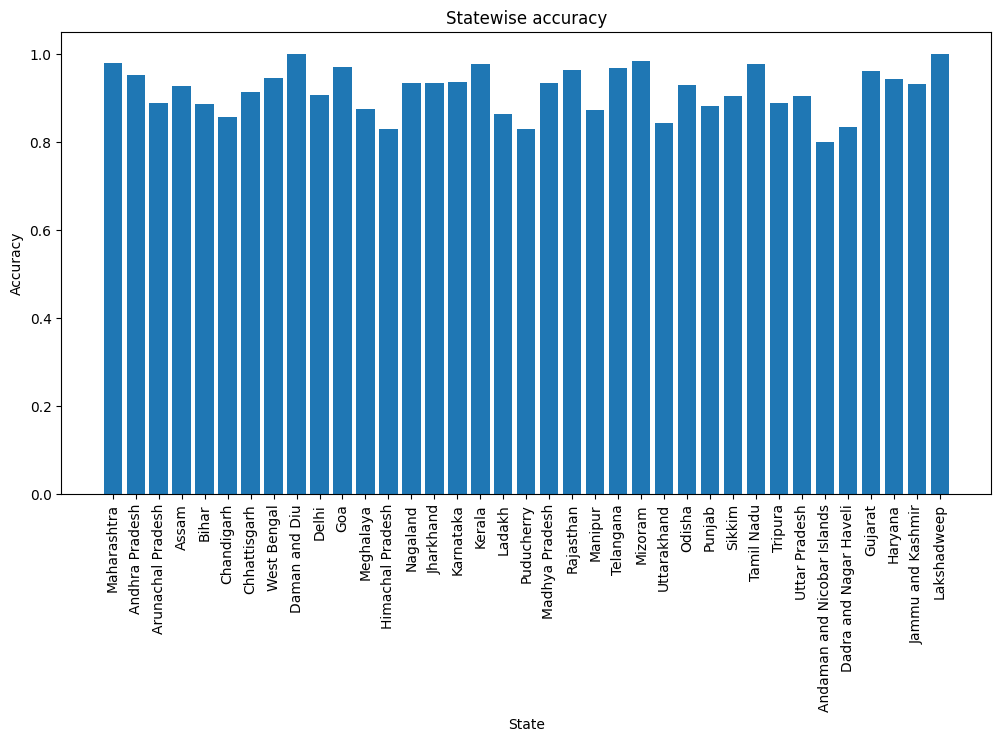

In [14]:
# display the results in a bar graph
plt.figure(figsize=(12, 6))
plt.bar(statewise_accuracy.keys(), statewise_accuracy.values())
# arrange the xticks vertically
plt.xticks(rotation=90)
plt.title("Statewise accuracy")
plt.xlabel("State")
plt.ylabel("Accuracy")
plt.show()

In [44]:
import Bio
from Bio.Align import PairwiseAligner
from Bio.Align import substitution_matrices
import cv2

In [ ]:
# align two sequences
seq1 = np.random.choice(df["Sequence"])
seq2 = np.random.choice(df["Sequence"])

seq1 = Bio.Seq.Seq(seq1)
seq2 = Bio.Seq.Seq(seq2)

aligner = PairwiseAligner()
aligner.mode = "global"
#aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")

alignments = aligner.align(seq1, seq2)

# get the best alignment
best_alignment = alignments[0]